## Курсовой проект для курса "Python для Data Science"

### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Подключение зависимостей

In [300]:
import pandas as pd
import numpy as np

#### Загрузка данных

In [328]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Первичная обработка

In [302]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [ ]:
features_to_scale = ['Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Social_2']

In [303]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Явно проблемные данные:
- Rooms min=0. Подозрительно нулевое количество комнат.
- Square min=1.13 Слишком малая площадь для недвижимости. Туалет?
- Square max=641, но LifeSquare max=7480 и KitchenSquare max=2014. Общая площадь меньше, чем жилая и кухни.
- Непонятные цифры в HouseYear.
- Судья по перцентилям и среднему - в Square, LifeSquare и KitchenSquare возможны выбросы.

In [304]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [444]:
df.nunique()

Id                5203
DistrictId         171
Rooms                9
Square            5203
LifeSquare        4458
KitchenSquare       39
Floor               33
HouseFloor          42
HouseYear           96
Ecology_1           76
Ecology_2            3
Ecology_3            3
Social_1            44
Social_2            85
Social_3            27
Healthcare_1        79
Helthcare_2          8
Shops_1             16
Shops_2              3
Price             5203
LifeSquare_nan       2
Healthcare_nan       2
A                    3
B                    3
A                    3
B                    3
A                    3
B                    3
A                    3
B                    3
A                    3
B                    3
A                    3
B                    3
900.0                2
A                    2
B                    2
900.0                2
A                    2
B                    2
900.0                2
A                    2
B                    2
900.0      

В LifeSquare и Healthcare_1 присутствуют null.

In [329]:
# Номинативные данные
df_obj_features = df.select_dtypes(include='object')
df_obj_features

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,A
9998,B,A,B


In [330]:
for feature in df_obj_features.columns:
    print(feature)
    print(f'nunique: {df_obj_features[feature].nunique()}')
    print(f'unique: {df_obj_features[feature].unique()}\n')

Ecology_2
nunique: 2
unique: ['B' 'A']

Ecology_3
nunique: 2
unique: ['B' 'A']

Shops_2
nunique: 2
unique: ['B' 'A']



In [331]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

LifeSquare nulls = 2113. Судя по всему - это коммерческая недвижимость(нет, т.к. KitchenSquare указана у всех).
Healthcare_1 nulls = 4798. Почти в половине данных признак отсутствует.

### Визуализация и анализ данных

#### Подключение зависимостей

In [309]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [310]:
matplotlib.rcParams.update({'font.size': 14})

In [311]:
target = df['Price']

#### Распределение целевой переменной

In [312]:
def distribution_plot(series, label):
    plt.figure(figsize=(16, 8))

    mean = round(series.mean(), 2)
    median = series.median()

    plt.subplot(121)
    series.hist(density=False, bins=20)
    plt.ylabel('count')
    plt.xlabel(label)

    y = np.linspace(0, 2000, 2)
    plt.plot([mean] * 2, y, label='mean', linewidth=4)
    plt.plot([median] * 2, y, label='median', linewidth=4)
    plt.legend()

    plt.subplot(122)
    sns.kdeplot(series, shade=True, legend=False)
    plt.xlabel(label)

    plt.suptitle(label)
    plt.show()

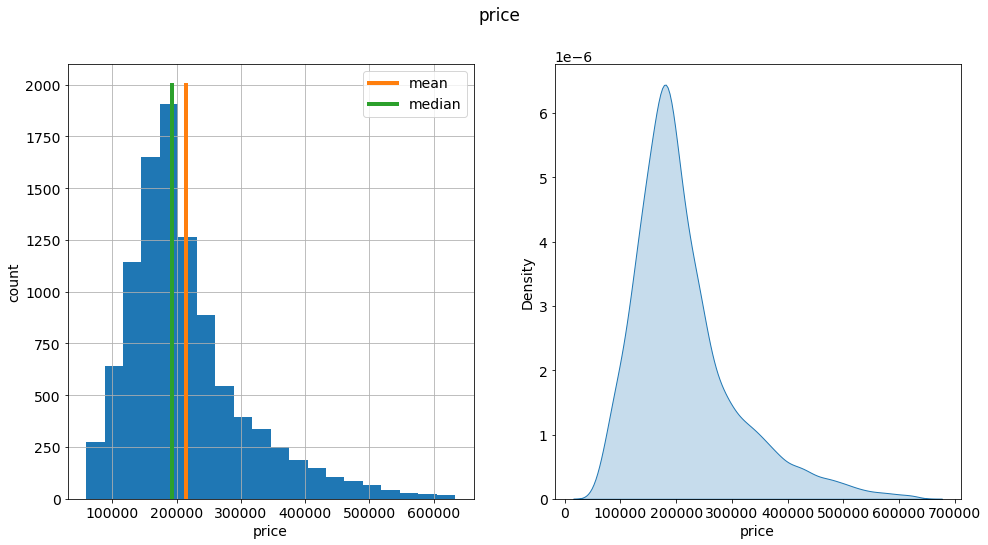

In [313]:
distribution_plot(target, 'price')

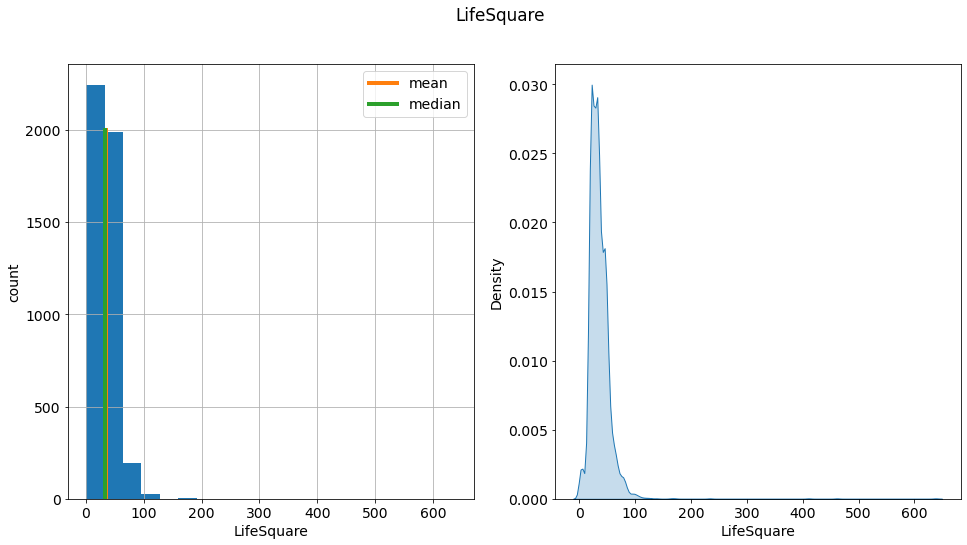

In [314]:
# Распределение LifeSquare
distribution_plot(df.dropna()['LifeSquare'], 'LifeSquare')

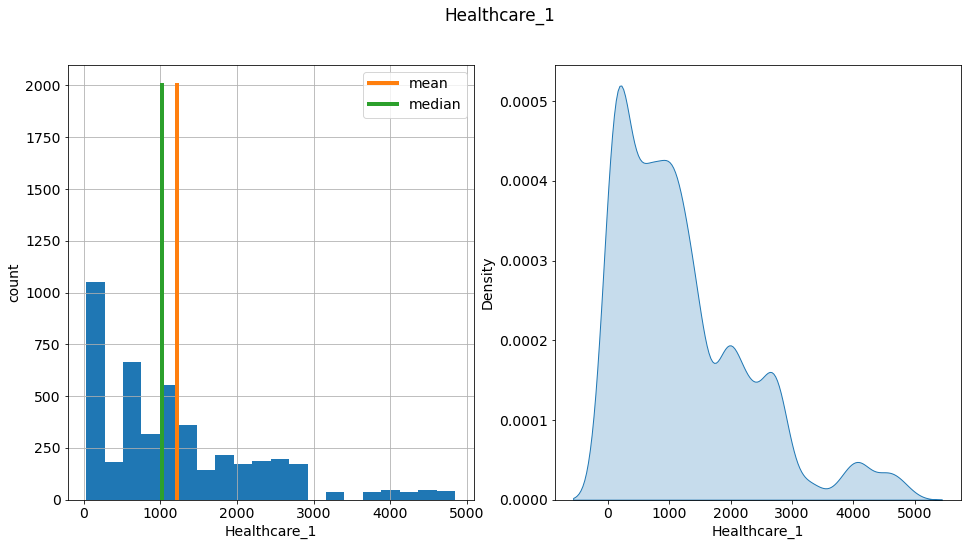

In [332]:
# Распределение Healthcare_1
distribution_plot(df.dropna()['Healthcare_1'], 'Healthcare_1')

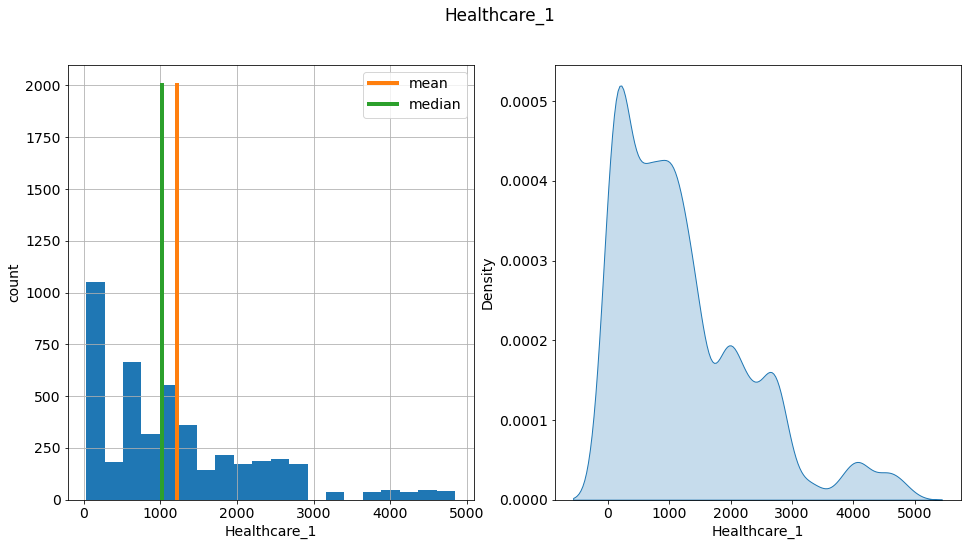

In [316]:
# Распределение Healthcare_1
distribution_plot(df.dropna()['Healthcare_1'], 'Healthcare_1')

### Трансформация данных

In [387]:
# Пропуски

# LifeSquare
df['LifeSquare_nan'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

# Healthcare_1
df[df['Healthcare_1'].isna()] = df['Healthcare_1'].median()
# df['Healthcare_nan'] = 0
# df.loc[df['Healthcare_1'].isna(), 'Healthcare_nan'] = 1

In [388]:
# Обработка категорий
df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,B,900.0,A,B,900.0,A,B,900.0,A,B
0,900,900,900.0,900.000000,900.000000,900.0,900,900.0,900,900.000000,...,0,1,0,0,1,0,0,1,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,0,0,1,0,0,1,0,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,0,0,1,0,0,1,0,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,0,0,1,0,0,1,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,0,0,1,0,0,1,0,0,1


### Анализ признаков

#### Количественные признаки

In [389]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features = df_num_features.drop('Price', axis=1)
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_nan
0,900,900,900.0,900.000000,900.000000,900.0,900,900.0,900,900.000000,900,900,900,900.0,900,900,0,900
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,0,0


#### Базовая проверка r2 с помощью линейной регрессии

In [321]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = df_num_features.drop(columns=['LifeSquare'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)

0.8265242545869147

In [322]:
# Drop Healthcare_1
x = x.drop(columns=['Healthcare_1'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)

0.824814167493255

In [336]:
x = df_num_features.drop(columns=['LifeSquare'])
x = x.drop(columns=['Healthcare_1'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)

0.4596401006067782

In [367]:
# Дропнул выбросы Square.
x = df_num_features.drop(columns=['LifeSquare'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)
# Точность повысилась на 0.0022922396955238344

0.8288164942824385

In [396]:
# Дропнул выбросы KitchenSquare.
x = df_num_features.drop(columns=['LifeSquare'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)
# Точность понизилась на 1.3100631690576847e-14. Поработать дополнительно с KitchenSquare.

0.8288164942824254

In [392]:
0.8288164942824254-0.8288164942824385

-1.3100631690576847e-14

In [397]:
# Дропнул id
x = x.drop(columns=['Id'])
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)
# Точность понизилась (?) на -2.6688912350358862e-05

0.8287898053700751

In [426]:
y_pred_train = lr.predict(x_train)
r2_score(y_train, y_pred_train)

0.8542809125022431

In [428]:
# Модуль переобучена
0.8542809125022431-0.8287898053700751

0.025491107132168067

In [398]:
0.8287898053700751-0.8288164942824254

-2.6688912350358862e-05

In [420]:
# Стандартизация признаков
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)

0.8287898053700292

In [421]:
0.8287898053700292-0.8287898053700751

-4.5852210917018965e-14

### Проблемы:
- Healthcare_1 почти половина nan. Заполнять медианой - проблема: серьезно аффектит модель. При дропе r2_score слегка понизился.
- Следует дропнуть id
- В проверках выбросов ошибки - использую df, а не df_copy.

### Исследования

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


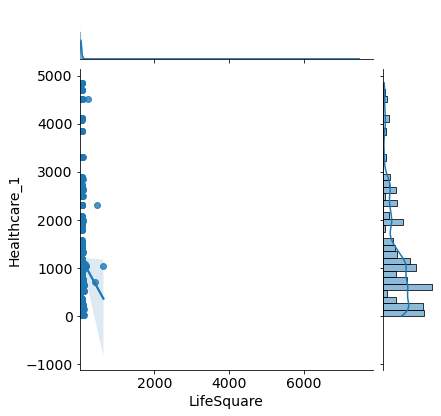

In [338]:
grid = sns.jointplot(df['LifeSquare'], df['Healthcare_1'], kind='reg')
plt.show()

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


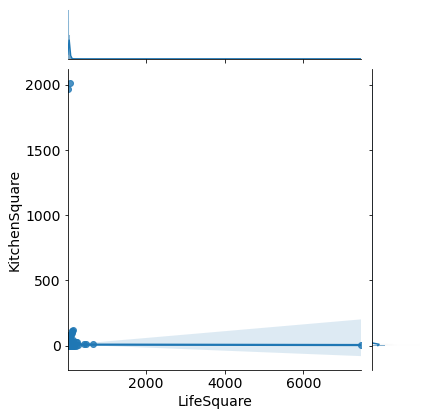

In [339]:
grid = sns.jointplot(df['LifeSquare'], df['KitchenSquare'], kind='reg')
plt.show()

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Square'>

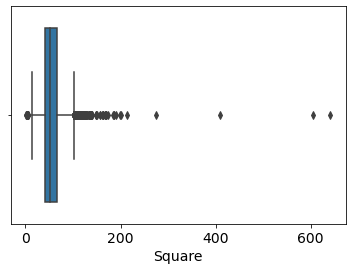

In [340]:
# Выбросы Square, LifeSquare и KitchenSquare
sns.boxplot(df['Square'], whis=1.5)

In [341]:
df[df['Square'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,B,455264.882666,0,0,0,1,1,0,0,1
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,...,B,187717.242538,1,0,0,1,0,1,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,B,90470.430830,0,0,0,1,0,1,0,1
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,B,133529.681562,0,0,0,1,0,1,0,1


- id 5548 - ok
- id 28 - явно ошибочные данные. Слишком большой Square, KitchenSquare = 1 и LifeSquare=NaN.
- id 2307 - также ошибочные данные. Огромная площадь, и слишком малая цена. Жилая и площадь кухни больше общей.
- id 11602 - ошибочные данные. Жилая и площадь кухни больше общей. Этаж больше количества этажей в доме.

In [344]:
id_square_to_drop = ['28', '2307', '11602']
df[df.Id.isin(id_square_to_drop)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,...,B,187717.242538,1,0,0,1,0,1,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,B,90470.430830,0,0,0,1,0,1,0,1
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,B,133529.681562,0,0,0,1,0,1,0,1


In [345]:
df.drop?

In [347]:
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              10000 non-null  int64  
 1   DistrictId      10000 non-null  int64  
 2   Rooms           10000 non-null  float64
 3   Square          10000 non-null  float64
 4   LifeSquare      7887 non-null   float64
 5   KitchenSquare   10000 non-null  float64
 6   Floor           10000 non-null  int64  
 7   HouseFloor      10000 non-null  float64
 8   HouseYear       10000 non-null  int64  
 9   Ecology_1       10000 non-null  float64
 10  Ecology_2       10000 non-null  object 
 11  Ecology_3       10000 non-null  object 
 12  Social_1        10000 non-null  int64  
 13  Social_2        10000 non-null  int64  
 14  Social_3        10000 non-null  int64  
 15  Healthcare_1    5202 non-null   float64
 16  Helthcare_2     10000 non-null  int64  
 17  Shops_1         10000 non-null  

In [349]:
df_copy.drop(df[df.Id.isin(id_square_to_drop)].index, inplace=True)

In [350]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              9997 non-null   int64  
 1   DistrictId      9997 non-null   int64  
 2   Rooms           9997 non-null   float64
 3   Square          9997 non-null   float64
 4   LifeSquare      7885 non-null   float64
 5   KitchenSquare   9997 non-null   float64
 6   Floor           9997 non-null   int64  
 7   HouseFloor      9997 non-null   float64
 8   HouseYear       9997 non-null   int64  
 9   Ecology_1       9997 non-null   float64
 10  Ecology_2       9997 non-null   object 
 11  Ecology_3       9997 non-null   object 
 12  Social_1        9997 non-null   int64  
 13  Social_2        9997 non-null   int64  
 14  Social_3        9997 non-null   int64  
 15  Healthcare_1    5199 non-null   float64
 16  Helthcare_2     9997 non-null   int64  
 17  Shops_1         9997 non-null   i

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Square'>

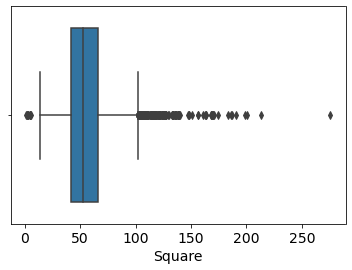

In [352]:
sns.boxplot(df_copy['Square'], whis=1.5)

In [354]:
x = df_copy
y = df.Price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

r2_score(y_test, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [9997, 10000]

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LifeSquare'>

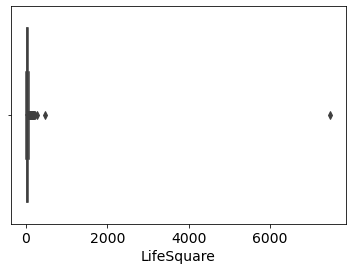

In [353]:
sns.boxplot(df_copy['LifeSquare'], whis=1.5)
# TODO: Обработать позже. Сейчас весь LifeSquare дропается.

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='KitchenSquare'>

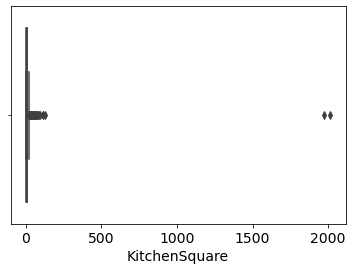

In [369]:
sns.boxplot(df_copy['KitchenSquare'], whis=1.5)

In [370]:
df_copy[df_copy.KitchenSquare > 500]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,A,108337.484207,0,1,0,1,0,1,1,0
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,B,105539.556275,0,0,0,1,0,1,0,1


- id 14656 - в KitchenSquare попал год, Floor > HouseFloor

In [372]:
df_copy[df.DistrictId==62]

<ipython-input-372-30d2a5fece63>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy[df.DistrictId==62]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
3657,2149,62,3.0,61.586468,46.508579,6.0,7,9.0,1979,0.037178,...,B,240804.697900,0,0,0,1,0,1,0,1
5846,3987,62,3.0,54.208702,35.696251,6.0,5,9.0,1977,0.037178,...,B,247485.467014,0,0,0,1,0,1,0,1
6347,15491,62,3.0,54.127769,36.769458,6.0,4,9.0,1978,0.037178,...,B,241930.174522,0,0,0,1,0,1,0,1
6694,14250,62,2.0,44.482913,30.682335,6.0,7,9.0,1977,0.037178,...,B,222637.361251,0,0,0,1,0,1,0,1
6811,4420,62,1.0,35.665148,21.079453,6.0,4,9.0,1977,0.037178,...,B,150721.427612,0,0,0,1,0,1,0,1
6851,3486,62,1.0,33.071807,22.237242,6.0,2,9.0,1979,0.037178,...,B,154480.967956,0,0,0,1,0,1,0,1
7399,14357,62,3.0,49.017240,34.960039,6.0,7,9.0,1980,0.037178,...,B,123280.909753,0,0,0,1,0,1,0,1
8415,816,62,3.0,81.095350,48.902406,10.0,11,16.0,1976,0.037178,...,B,380878.513736,0,0,0,1,0,1,0,1
8927,1034,62,1.0,36.190302,17.996515,6.0,2,9.0,1979,0.037178,...,B,162537.996292,0,0,0,1,0,1,0,1


Видно, что в этом округе 62 все дома значительно старее и экология значительно отличается. Слишком много несходящихся данных, полезеность наблюдения минимальна - удаляем.

- id 14679 - Floor > HouseFloor.

In [373]:
df_copy[df.DistrictId==81]

<ipython-input-373-5baa70656988>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy[df.DistrictId==81]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
290,13049,81,3.0,71.045992,52.836433,7.0,3,5.0,1960,0.319809,...,B,286325.097046,0,0,0,1,0,1,0,1
1368,14597,81,3.0,66.632281,45.460596,9.0,6,12.0,1976,0.319809,...,B,343789.188429,0,0,0,1,0,1,0,1
1828,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,...,B,526817.563339,0,0,0,1,0,1,0,1
2325,9335,81,3.0,76.251492,47.228138,8.0,10,11.0,1955,0.319809,...,B,411442.836347,0,0,0,1,0,1,0,1
3261,6084,81,1.0,47.399294,21.586000,10.0,7,17.0,2011,0.006076,...,B,169603.426887,0,0,0,1,0,1,0,1
3334,283,81,2.0,56.984833,36.377299,7.0,2,5.0,1963,0.006076,...,B,240738.133672,0,0,0,1,0,1,0,1
3566,12672,81,3.0,86.385126,52.607466,7.0,3,10.0,1955,0.319809,...,B,420583.792067,0,0,0,1,0,1,0,1
4720,3516,81,1.0,46.969985,19.215402,9.0,9,24.0,2014,0.319809,...,B,203894.398945,0,0,0,1,0,1,0,1
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,...,B,78388.806186,0,0,0,1,0,1,0,1
4915,13422,81,2.0,37.546278,25.338900,1.0,3,9.0,1977,0.319809,...,B,193355.996896,0,0,0,1,0,1,0,1


По id 14679 много вопросов. KitchenSquare, HouseFloor - битые данные. Цена меньше в 2 раза чем квартира в похожем доме. Экология сильно отличается по дому.

In [381]:
df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977]

<ipython-input-381-6476a75d6256>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
4915,13422,81,2.0,37.546278,25.338900,1.0,3,9.0,1977,0.319809,...,B,193355.996896,0,0,0,1,0,1,0,1
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,B,105539.556275,0,0,0,1,0,1,0,1


<ipython-input-383-5c55c66308c3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977].hist(figsize=(16, 16), grid=False)


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>],
       [<AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'LifeSquare_nan'}>,
        <AxesSubplot:title={'center':'Healthcare_nan'}>,
        <AxesS

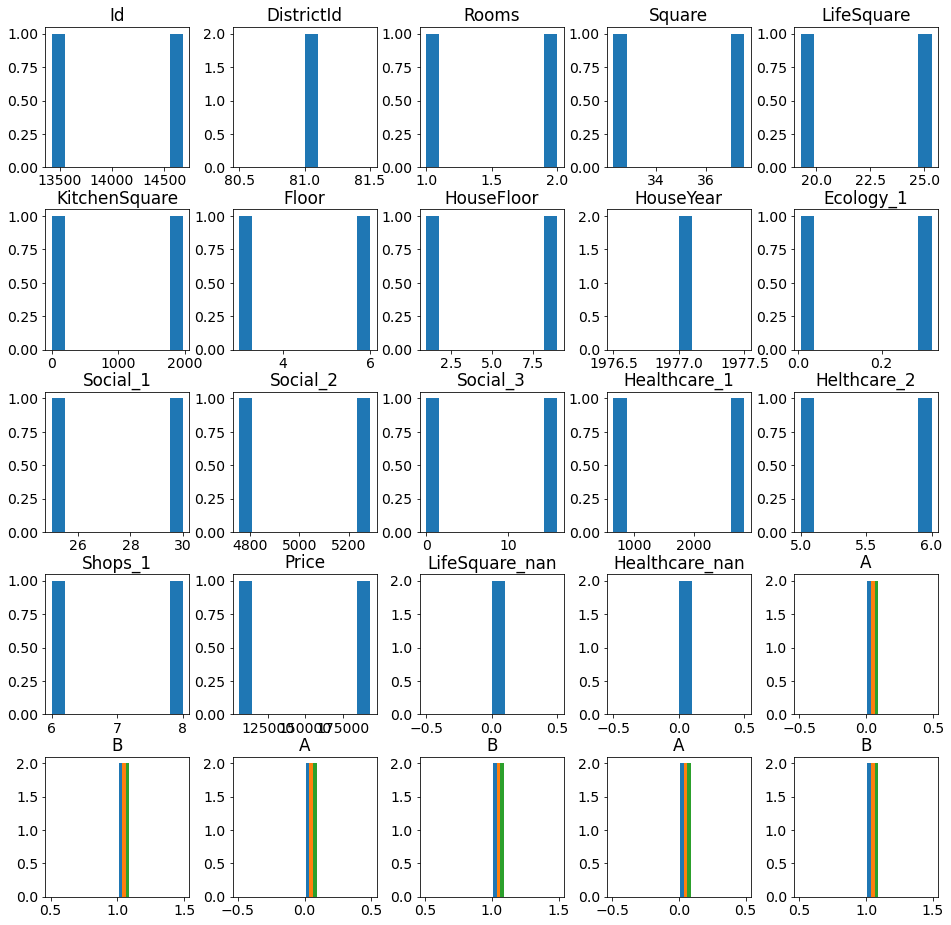

In [383]:
df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977].hist(figsize=(16, 16), grid=False)

In [385]:
# Много вопросов по id 14679. Пока что дропаю.
df_copy.drop(df_copy[df_copy.Id==14679].index, inplace=True)

In [386]:
df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977]

<ipython-input-386-6476a75d6256>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy[df_copy.DistrictId==81][df_copy.HouseYear == 1977]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_nan,Healthcare_nan,A,B,A,B,A,B
4915,13422,81,2.0,37.546278,25.3389,1.0,3,9.0,1977,0.319809,...,B,193355.996896,0,0,0,1,0,1,0,1


## !!! Наблюдаются явные расхождения по Ecology_1 внутри округа. Проверить Ecology_1 на выбросы.

Также интересно посмотреть на зависимости внутри округов.

### Матрица корреляций

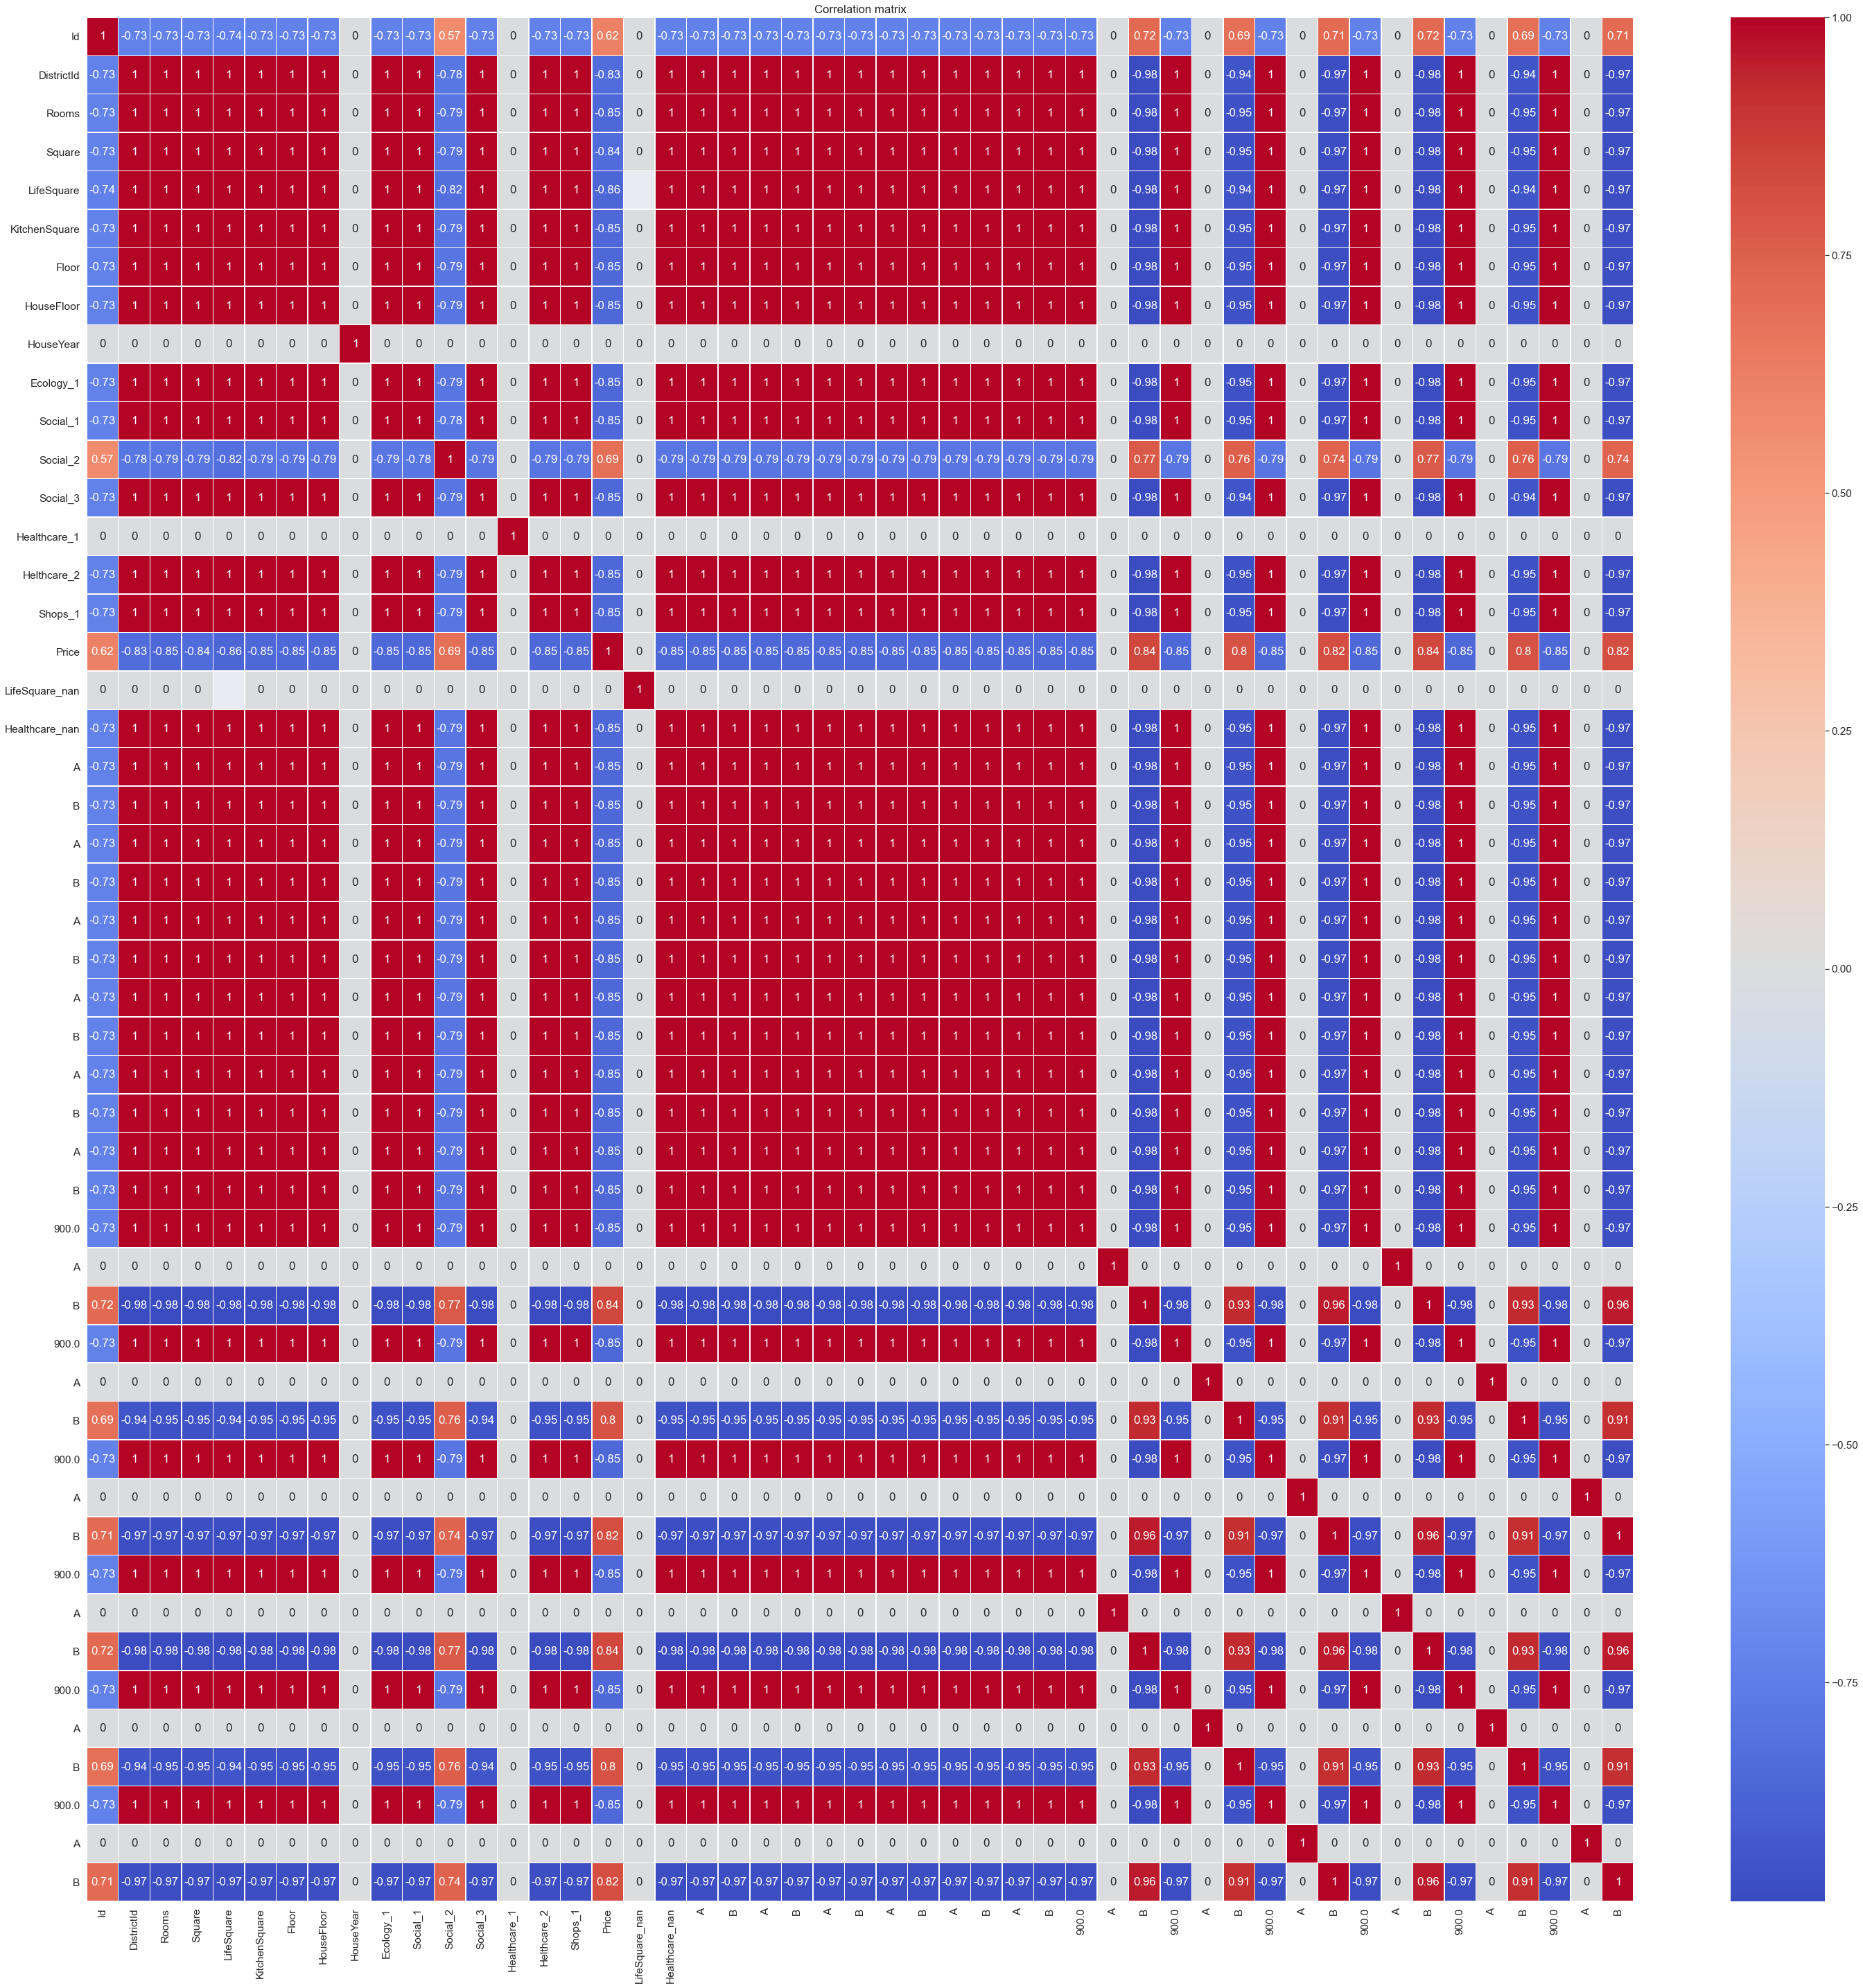

In [401]:
plt.figure(figsize = (50,50))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

<BarContainer object of 16 artists>

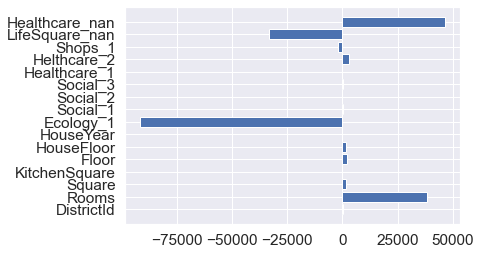

In [410]:
# Вклад коэффициентов
plt.barh(x.columns.values, lr.coef_.flatten())

<BarContainer object of 16 artists>

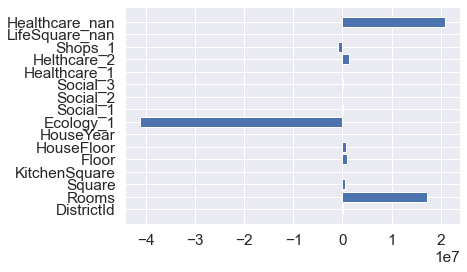

In [429]:
# Вклад коэффициентов после стандартизации
plt.barh(x.columns.values, lr.coef_.flatten())

Видим, что подозрительно большие веса у _nan и очень большой вес у Ecology_1.

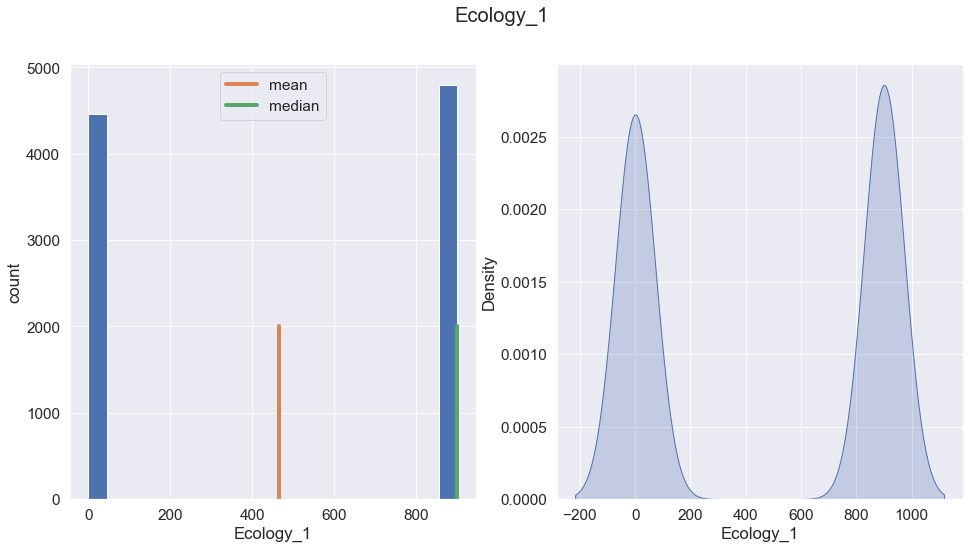

In [411]:
# Проверка Ecology_1
distribution_plot(df.dropna()['Ecology_1'], 'Ecology_1')

Кажется, в Ecology_1 нет ничего подозрительного. Возможно, разница между центром города и окраиной.

## !!! Требуется стандартизация! Для устранения сильного влияния Ecology_1

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


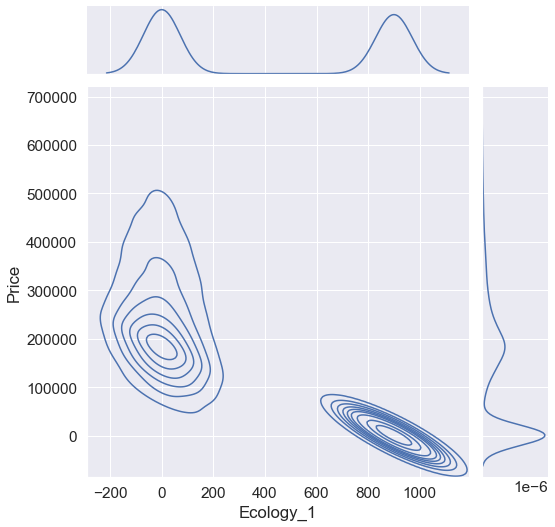

In [414]:
# Анализ влияния Ecology_1 на цены
grid = sns.jointplot(df['Ecology_1'], df['Price'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

### Стандартизация признаков

In [447]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Social_2']
scaler = StandardScaler()

In [451]:
x[features_to_scale].head()

KeyError: "['LifeSquare'] not in index"

In [450]:
stand_features = scaler.fit_transform(x[features_to_scale])

KeyError: "['LifeSquare'] not in index"

In [418]:
stand_features.shape

(10000, 16)

In [419]:
x = pd.DataFrame(stand_features, columns=x.columns.values)

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_nan
0,1.037841,1.041249,1.040499,1.040216,1.041214,1.041190,-0.012810,1.041250,1.041002,-0.822378,1.039846,-0.169240,1.041247,1.041213,-0.28372,1.041250
1,-0.997918,-0.957983,-0.936026,-0.956426,-0.963072,-0.968008,-0.007433,-0.960707,-0.919471,2.141320,-0.986542,-1.053217,-0.962387,-0.935930,-0.28372,-0.960384
2,-0.969479,-0.960211,-0.985150,-0.974333,-0.960828,-0.961243,-0.007483,-0.960597,-0.947018,1.338107,-0.988796,-1.067950,-0.962387,-0.965006,-0.28372,-0.960384
3,-0.957630,-0.960211,-0.965238,-0.954188,-0.960828,-0.949968,-0.007438,-0.959733,-0.972270,0.700576,-0.982034,0.077202,-0.964616,-0.960533,-0.28372,-0.960384
4,-0.860463,-0.962440,-0.997703,-0.958664,-0.954094,-0.961243,-0.007443,-0.960680,-0.944723,0.713491,-0.986542,1.408526,-0.960158,-0.962769,-0.28372,-0.960384


In [423]:
x.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_nan
0,1.037841,1.041249,1.040499,1.040216,1.041214,1.041190,-0.012810,1.041250,1.041002,-0.822378,1.039846,-0.169240,1.041247,1.041213,-0.28372,1.041250
1,-0.997918,-0.957983,-0.936026,-0.956426,-0.963072,-0.968008,-0.007433,-0.960707,-0.919471,2.141320,-0.986542,-1.053217,-0.962387,-0.935930,-0.28372,-0.960384
2,-0.969479,-0.960211,-0.985150,-0.974333,-0.960828,-0.961243,-0.007483,-0.960597,-0.947018,1.338107,-0.988796,-1.067950,-0.962387,-0.965006,-0.28372,-0.960384
3,-0.957630,-0.960211,-0.965238,-0.954188,-0.960828,-0.949968,-0.007438,-0.959733,-0.972270,0.700576,-0.982034,0.077202,-0.964616,-0.960533,-0.28372,-0.960384
4,-0.860463,-0.962440,-0.997703,-0.958664,-0.954094,-0.961243,-0.007443,-0.960680,-0.944723,0.713491,-0.986542,1.408526,-0.960158,-0.962769,-0.28372,-0.960384


In [430]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,B,900.0,A,B,900.0,A,B,900.0,A,B
0,900,900,900.0,900.000000,900.000000,900.0,900,900.0,900,900.000000,...,0,1,0,0,1,0,0,1,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,0,0,1,0,0,1,0,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,0,0,1,0,0,1,0,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,0,0,1,0,0,1,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,0,0,1,0,0,1,0,0,1


In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              10000 non-null  int64  
 1   DistrictId      10000 non-null  int64  
 2   Rooms           10000 non-null  float64
 3   Square          10000 non-null  float64
 4   LifeSquare      9255 non-null   float64
 5   KitchenSquare   10000 non-null  float64
 6   Floor           10000 non-null  int64  
 7   HouseFloor      10000 non-null  float64
 8   HouseYear       10000 non-null  int64  
 9   Ecology_1       10000 non-null  float64
 10  Ecology_2       10000 non-null  object 
 11  Ecology_3       10000 non-null  object 
 12  Social_1        10000 non-null  int64  
 13  Social_2        10000 non-null  int64  
 14  Social_3        10000 non-null  int64  
 15  Healthcare_1    10000 non-null  float64
 16  Helthcare_2     10000 non-null  int64  
 17  Shops_1         10000 non-null  

### !!! Стандартизировать нужно только для float64, 32 и т.д.
1/0 стандартизировать не нужно

In [431]:
# TODO:
# - Почистить, удалить ненужное, замерять переобучение, стандартизировать и замерить r2 и переобучение.

In [435]:
# Проверка актуальности выбросов для тестовой модели
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LifeSquare'>

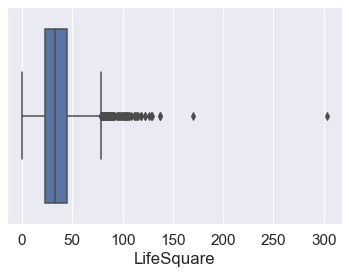

In [436]:
sns.boxplot(test['LifeSquare'], whis=1.5)

In [439]:
# price per meter by district
price_meter = train.groupby('DistrictId')[['Square', 'Price']].sum().reset_index()
price_meter['unit_price'] = price_meter['Price'] / price_meter['Square']
price_meter = price_meter[['DistrictId', 'unit_price']]
price_meter

,DistrictId,unit_price
0,0,3580.128227
1,1,3175.209200
2,2,4523.617804
3,3,3588.170925
4,4,4490.922499
...,...,...
200,202,5775.486120
201,205,5101.016598
202,207,5550.678339
203,208,8004.659114


In [440]:
train = pd.merge(train, price_meter, how='left', on='DistrictId')
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,unit_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,4366.167054
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,4241.295364
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,4766.966334
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,2957.990008
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,3878.845206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,...,B,46,7960,6,350.0,3,11,B,196684.316040,4940.495992
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,B,30,5562,0,NaN,0,5,A,189050.289571,3787.535658
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,...,B,2,629,1,NaN,0,0,A,159143.805370,2715.704541
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,A,30,5048,9,325.0,2,5,B,181595.339808,4208.013270
